In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import time
import warnings
import random
warnings.filterwarnings('ignore')

# AutoML을 이용한 ML 구현
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Binarizer
from sklearn.model_selection import KFold, GridSearchCV
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder

In [3]:
df = pd.read_csv('./diabetes.csv')

In [4]:
# missing value == 0
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [6]:
# Pregnancies: 임신 횟수
# Glucose: 포도당 검사 수치
# BloodPressure: 혈압
# SkinThickness: 피하지방 측정값
# Insulin: 혈철 인슐린 양
# BMI
# DiabetesPedigreeFunction: 당뇨 내력 가중치 값
# Age

In [7]:
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [8]:
print('length of value counts')
for col in df.columns:
    print(f'{col} : {len(df[col].value_counts())}')

length of value counts
Pregnancies : 17
Glucose : 136
BloodPressure : 47
SkinThickness : 51
Insulin : 186
BMI : 248
DiabetesPedigreeFunction : 517
Age : 52
Outcome : 2


In [9]:
print('count of zero values')
columns = [col for col in df.columns if col != 'Outcome']
for col in columns:
    print(f'{col} : {len(df[df[col] == 0][col])}')
    
# BMI, BloodPressure, Glucose have missing values as 0

count of zero values
Pregnancies : 111
Glucose : 5
BloodPressure : 35
SkinThickness : 227
Insulin : 374
BMI : 11
DiabetesPedigreeFunction : 0
Age : 0


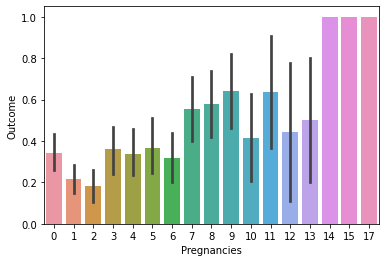

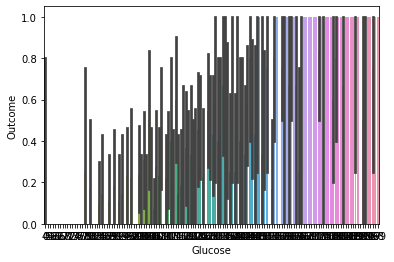

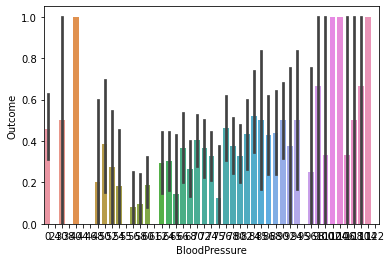

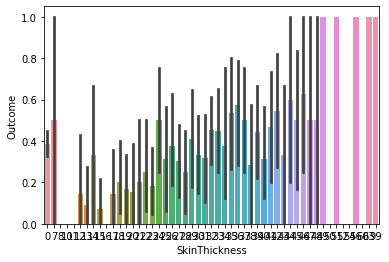

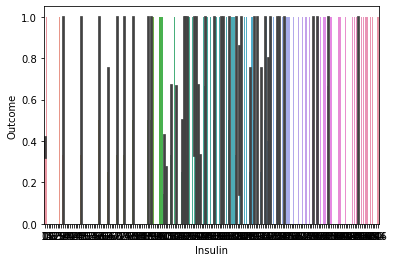

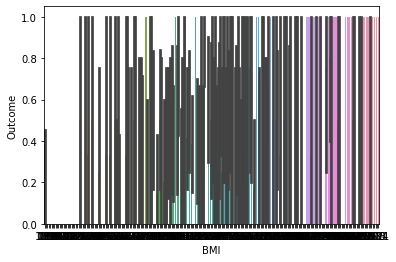

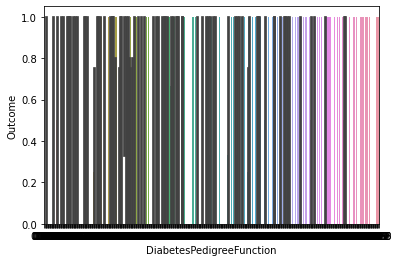

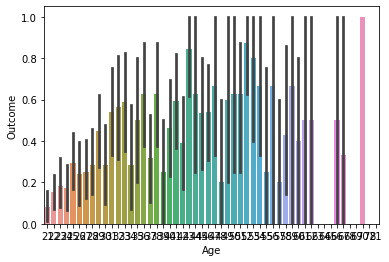

In [10]:
columns = [col for col in df.columns if col != 'Outcome']
for col in columns:
    # df.groupby(col)['Outcome'].mean()
    sns.barplot(x=col, y='Outcome', data=df)
    plt.show()

In [11]:
def convert_missing_values_to_average_value(df, cols):
    def get_average_value_except_zero(df, col):
        series = df[col]
        cnt = 0
        total_value = 0
        for i in series:
            if i != 0:
                total_value += i
                cnt += 1
        if col == 'BMI':
            return float(total_value/cnt)
        else:
            return int(total_value/cnt)

    for col in cols:
        avg = get_average_value_except_zero(df, col)
        df[col] = df[col].replace(0, avg)
    
    return df

In [12]:
def train_model(X_train_x, y_train):
    pipe = Pipeline([('preprocessing', None), ('classifier', None)])
    pre_list = [StandardScaler(), MinMaxScaler(), None]
    hyperparam_grid = [
        # classification
        # LogisticRegression
        {'classifier': [LogisticRegression()], 'preprocessing': pre_list,
         'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
#         # DecisionTree
#         {'classifier': [DecisionTreeClassifier()], 'preprocessing': pre_list,
#          'classifier__max_depth': [3, 5, 7, 11], 'classifier__min_samples_split': [2, 3, 5],
#          'classifier__min_samples_leaf': [1, 5, 8]},
#         # RandomForest
#         {'classifier': [RandomForestClassifier()], 'preprocessing': pre_list,
#          'classifier__max_depth': [5, 6, 7, 8, 9], 'classifier__min_samples_split': [3, 4, 5],
#          'classifier__min_samples_leaf': [1, 2]},
#         # Support Vector Classifier
#         {'classifier': [SVC()], 'preprocessing': pre_list,
#          'classifier__C': [0.1, 1, 3, 5, 10], 'classifier__kernel': ['poly', 'rbf', 'sigmoid'],
#          'classifier__gamma': ['scale', 'auto']},
#         # Gradient Boosting Classifer
#         {'classifier': [GradientBoostingClassifier()], 'preprocessing': pre_list,
#          'classifier__learning_rate': [0.001, 0.01, 0.1, 1, 3, 5],
#          'classifier__n_estimators': [30, 50, 100, 200]},
#         # Gaussian Naive Bayes
#         {'classifier': [GaussianNB()], 'preprocessing': pre_list},
#         # XGB
#         {'classifier': [XGBClassifier(eval_metric='mlogloss')],
#          'preprocessing': pre_list,
#          'classifier__learning_rate': [0.0, 0.1, 0.09, 0.089, 0.08],
#          'classifier__booster': ['gbtree', 'gblinear', 'dart']}
        
#         # Regrssion
#         # LinearRegression
#         {'regressor': [LogisticRegression()], 'preprocessing': pre_list,
#          'regressor__C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
#         # Ridge
#         {'regressor': [Ridge()], 'preprocessing': pre_list,
#          'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
#         # Lasso
#         {'regressor': [Lasso()], 'preprocessing': pre_list,
#          'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
#         # Support Vector Regressor
#         {'regressor': [SVR()], 'preprocessing': pre_list,
#          'regressor__epsilon': [0.001, 0.01, 0.1, 1, 10],
#          'regressor__C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
#         # MLP
#         {'regressor': [MLPRegressor()], 'preprocessing': pre_list,
#          'regressor__hidden_layer_sizes': [(100,) , (10, 10, )],
#          'regressor__activation': ['relu', 'logistic'],
#          'regressor__solver': ['lbfgs', 'adam'],
#          'regressor__alpha': [0.0001, 0.01, 1]},
#         # XGB
#         {'regressor': [XGBRegressor(objective='reg:squarederror')],
#          'preprocessing': pre_list,
#          'regressor__learning_rate': [0.0, 0.1, 0.09, 0.089, 0.08],
#          'regressor__booster': ['gbtree', 'gblinear', 'dart']}
    ]
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    grid = GridSearchCV(pipe, hyperparam_grid, scoring='accuracy', refit=True, cv=kfold)
    grid.fit(X_train, y_train)
    print(grid.best_estimator_)
    print(grid.best_params_)
    print(grid.best_score_)
    
    return grid

In [13]:
def precision_recall_curve_plot(y_test=None, pred_proba_c1=None):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

In [14]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)

    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    
    # ROC-AUC print 추가
    print(f'정확도: {accuracy}, 정밀도: {precision}, 재현율: {recall}, F1: {f1}, AUC:{roc_auc}')

In [15]:
def predict_and_evaluate(X_test, y_test, grid):    
    model = grid.best_estimator_
    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)[:, 1]
    
    precision_recall_curve_plot(y_test, pred_proba) 
    
    pred = pred.astype(int)
    df_pred = pd.DataFrame({'Predicted_Outcome': pred})
    
    return df_pred

In [16]:
def get_eval_by_threshold(X_test, y_test, grid):
    model = grid.best_estimator_
    thresholds = [0.3 , 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
    pred_proba = model.predict_proba(X_test)
    pred_proba_c1 = pred_proba[:,1].reshape(-1,1)
    
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict, pred_proba_c1)

In [17]:
def get_transformed_result(X_test, y_test, grid, threshold, df_transformed_pred):
    model = grid.best_estimator_
    pred_proba = model.predict_proba(X_test)
    pred_proba_c1 = pred_proba[:,1].reshape(-1,1)
    
    binarizer = Binarizer(threshold=threshold).fit(pred_proba_c1) 
    custom_predict = binarizer.transform(pred_proba_c1)
    print('임곗값:', threshold)
    get_clf_eval(y_test, custom_predict, pred_proba_c1)
    
    custom_predict = custom_predict.reshape(-1)
    custom_predict = custom_predict.astype(int)
    df_pred_transformed = pd.DataFrame({'Transformed_Predicted_Outcome': custom_predict})
    df_x = X_test.reset_index().drop(['index'], axis='columns')
    df_y = y_test.reset_index().drop(['index'], axis='columns')

    return df_x.join(df_y).join(df_pred).join(df_pred_transformed)

Pipeline(steps=[('preprocessing', None),
                ('classifier', LogisticRegression(C=0.001))])
{'classifier': LogisticRegression(C=0.001), 'classifier__C': 0.001, 'preprocessing': None}
0.7812293853073463
임곗값: 0.3
오차 행렬
[[80 49]
 [14 49]]
정확도: 0.671875, 정밀도: 0.5, 재현율: 0.7777777777777778, F1: 0.6086956521739131, AUC:0.8042328042328043
임곗값: 0.33
오차 행렬
[[85 44]
 [16 47]]
정확도: 0.6875, 정밀도: 0.5164835164835165, 재현율: 0.746031746031746, F1: 0.6103896103896105, AUC:0.8042328042328043
임곗값: 0.36
오차 행렬
[[89 40]
 [17 46]]
정확도: 0.703125, 정밀도: 0.5348837209302325, 재현율: 0.7301587301587301, F1: 0.6174496644295302, AUC:0.8042328042328043
임곗값: 0.39
오차 행렬
[[92 37]
 [19 44]]
정확도: 0.7083333333333334, 정밀도: 0.5432098765432098, 재현율: 0.6984126984126984, F1: 0.611111111111111, AUC:0.8042328042328043
임곗값: 0.42
오차 행렬
[[95 34]
 [20 43]]
정확도: 0.71875, 정밀도: 0.5584415584415584, 재현율: 0.6825396825396826, F1: 0.6142857142857143, AUC:0.8042328042328043
임곗값: 0.45
오차 행렬
[[98 31]
 [21 42]]
정확도: 0.7291666666666666, 정밀도

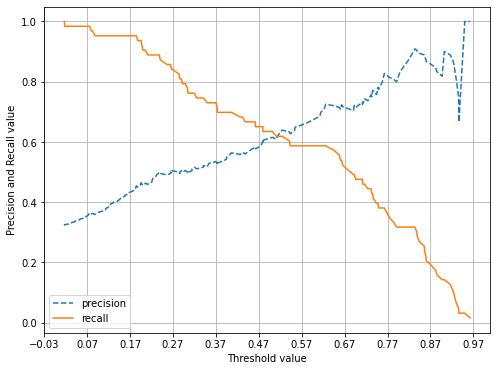

임곗값: 0.39
오차 행렬
[[92 37]
 [19 44]]
정확도: 0.7083333333333334, 정밀도: 0.5432098765432098, 재현율: 0.6984126984126984, F1: 0.611111111111111, AUC:0.8042328042328043
job running time: 1.1445930004119873 sec


In [18]:
start_time = time.time()
df = pd.read_csv('./diabetes.csv')
df = convert_missing_values_to_average_value(df, ['BMI', 'SkinThickness', 'Insulin'])
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Outcome'], axis='columns'), df['Outcome'])
                                                   
grid = train_model(X_train, y_train)
get_eval_by_threshold(X_test, y_test, grid)
df_pred = predict_and_evaluate(X_test, y_test, grid)

# A criterion to determine the best threshold is needed. e.g. f1, recall, precision, ...
df_result = get_transformed_result(X_test, y_test, grid, 0.39, df_pred)

print(f'job running time: {time.time() - start_time} sec')

In [19]:
pd.set_option('display.max_row', 500)
df_result.head(len(df_result))

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Predicted_Outcome,Transformed_Predicted_Outcome
0,0,118,64,23,89,32.457464,1.731,21,0,0,0
1,4,90,0,29,155,28.000000,0.610,31,0,0,0
2,1,172,68,49,579,42.400000,0.702,28,1,1,1
3,8,181,68,36,495,30.100000,0.615,60,1,1,1
4,8,99,84,29,155,35.400000,0.388,50,0,0,0
5,6,104,74,18,156,29.900000,0.722,41,1,0,0
6,4,95,70,32,155,32.100000,0.612,24,0,0,0
7,1,139,46,19,83,28.700000,0.654,22,0,0,0
8,12,140,85,33,155,37.400000,0.244,41,0,1,1
9,1,100,74,12,46,19.500000,0.149,28,0,0,0
